In [1]:
import pyspark as ps
from collections import Counter
import pandas as pd
import time
import matplotlib.pyplot as plt
spark = (ps.sql.SparkSession.builder 
        .master("local[4]") 
        .appName("nathanscope") 
        .getOrCreate()
        )

In [2]:
sc = spark.sparkContext

In [3]:
col_names = ['marketplace','customer_id','review_id','product_id','product_parent','product_title','product_category','star_rating','helpful_votes','total_votes','vine','verified_purchase','review_headline','review_body','review_date']
cols = {}
for i in range(len(col_names)):
    print (str(i)+': '+col_names[i])
    cols[col_names[i]] = i 

0: marketplace
1: customer_id
2: review_id
3: product_id
4: product_parent
5: product_title
6: product_category
7: star_rating
8: helpful_votes
9: total_votes
10: vine
11: verified_purchase
12: review_headline
13: review_body
14: review_date


In [4]:
def casting_function(row):
    if row[0] == 'marketplace':
        return ()
    if len(row)!=15:
        return(len(row))
    (marketplace, customer_id, review_id, product_id, product_parent, product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date) = row
    
    
    return (marketplace, str(customer_id), str(review_id), str(product_id), product_parent, str(product_title),str(product_category),int(star_rating),int(helpful_votes),int(total_votes),vine,verified_purchase,str(review_headline),str(review_body),review_date)




In [5]:
def time_cast(row):
    pattern = '%Y-%m-%d'
    row =list(row)
    row[14] = int(time.mktime(time.strptime(row[14], pattern)))/86400
    return tuple(row)

In [6]:
def toCSVLine(data):
  return ','.join(str(d) for d in data)

In [7]:
rdd_books = (sc.textFile('s3://amazon-reviews-pds/tsv/amazon_reviews_us_Books_v1_02.tsv.gz')
            .map(lambda rowstr : rowstr.split("\t"))
            .map(casting_function)
           )

In [8]:
rdd_books =rdd_books.filter(lambda x: len(x)==15).map(time_cast)

In [9]:
rdd_sample = rdd_books.filter(lambda x: x[14]%33>7).filter(lambda x: x[7]==1).filter(lambda x: x[9]>10)
#rdd_sample = rdd_books.filter(lambda x: x[7]==1)


star_counts = rdd_books.map(lambda x: Counter({x[cols['star_rating']]:1})).reduce(lambda x, y: x+y)

rdd_sample.count()

In [10]:
tiny_df = pd.DataFrame(rdd_sample.take(10))
tiny_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,US,27908248,R2YFB0IZEB4T6T,0786803207,215675580,William Wegman: Puppies,Books,1,2,12,N,N,Wegman Puppies - a little disturbing,Every year I buy my dad the Wegman puppies cal...,13067.0
1,US,39508730,R1PKZ1DV380CGE,0393327655,2927274,"The End of Faith: Religion, Terror, and the Fu...",Books,1,30,121,N,N,sophistry for dummies (yawn),All the world loves a villain; especially an a...,13067.0
2,US,23488741,R1TXSUPD0SNJ02,0060545607,485010020,With No One As Witness (Thomas Lynley and Barb...,Books,1,17,26,N,N,"Longer and longer, worse and worse","Unlike PD James, Ruth Rendall, or Donna Leon, ...",13067.0
3,US,49989805,R2W8FRD0MADJ6Q,0393317552,733405472,"Guns, Germs, and Steel: The Fates of Human Soc...",Books,1,22,55,N,N,This book is intellectually dishonest,The author cleary has an agenda. He is out to...,13067.0
4,US,42323108,R3E2DC2JLVRUFK,0441008534,486021067,Dead Until Dark (Sookie Stackhouse/True Blood...,Books,1,32,45,N,N,Disappointing.,"I read a lot, most of it this sort of thing, h...",13067.0
5,US,12096689,R1AJMOQSMHFSAS,1558687785,517014259,Thailand: A Quick Guide to Customs & Etiquette...,Books,1,8,11,N,N,theft,This book is a copy of Culture Shock! Thailand...,13067.0
6,US,23495398,RP9FT9CT39Z1F,0751537683,402742988,The Asti Spumante Code: A Parody,Books,1,0,16,N,N,Ugly shape for a book? If only it wasn't!,I agree with Plate of Pasta and Plate of Shrim...,13067.0
7,US,23496178,R2AA739QQ74G8,0060554738,80485164,The Game: Penetrating the Secret Society of Pi...,Books,1,13,39,N,N,another boring pickup book,"This is \\""NOT\\"" a book to pickup women nor d...",13067.0
8,US,50785465,R2EC3FWX5NALN7,094261741X,120755327,World War II: The Rest of the Story and How It...,Books,1,3,13,N,N,absurd view sprinkled with real facts,The premise of this ridiculous book is that th...,13067.0
9,US,52691483,R1E4NV2YM102KM,0972437746,774056158,No Mercy,Books,1,7,12,N,Y,A disapointing book in a good series,Giselle McKenzie decided that she was virgin l...,13067.0


In [11]:
#star_counts = rdd_sample.map(lambda x: Counter({x[cols['star_rating']]:1})).reduce(lambda x, y: x+y)

In [12]:
#rdd_sample.saveAsTextFile('file:///home/ec2-user/Amazon_Books/data/sample_02.tsv')

In [13]:
temp = pd.DataFrame(rdd_sample.collect())

sum(['x8b'in x for x in temp[14]])

temp.to_csv('cows.csv')

a = u'\xa1'
unicode(a, "utf-8")

a.decode('utf-8', 'ignore')

In [14]:
temp.to_csv('data/books_sample_1star_10vote.csv',index=False)

In [15]:
new_sample = pd.read_csv('data/books_sample_1star_10vote.csv')

In [16]:
helpful_percentage = []
for pos, total in zip(new_sample['8'],new_sample['9']):
    if total>0:
        helpful_percentage.append(float(pos)/float(total))
    else:
        helpful_percentage.append(0)

In [17]:
new_sample['15'] = helpful_percentage

In [18]:
help_df = new_sample[new_sample['8']>0]

In [19]:
help_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,US,27908248,R2YFB0IZEB4T6T,0786803207,215675580,William Wegman: Puppies,Books,1,2,12,N,N,Wegman Puppies - a little disturbing,Every year I buy my dad the Wegman puppies cal...,13067.0,0.166667
1,US,39508730,R1PKZ1DV380CGE,0393327655,2927274,"The End of Faith: Religion, Terror, and the Fu...",Books,1,30,121,N,N,sophistry for dummies (yawn),All the world loves a villain; especially an a...,13067.0,0.247934
2,US,23488741,R1TXSUPD0SNJ02,0060545607,485010020,With No One As Witness (Thomas Lynley and Barb...,Books,1,17,26,N,N,"Longer and longer, worse and worse","Unlike PD James, Ruth Rendall, or Donna Leon, ...",13067.0,0.653846
3,US,49989805,R2W8FRD0MADJ6Q,0393317552,733405472,"Guns, Germs, and Steel: The Fates of Human Soc...",Books,1,22,55,N,N,This book is intellectually dishonest,The author cleary has an agenda. He is out to...,13067.0,0.400000
4,US,42323108,R3E2DC2JLVRUFK,0441008534,486021067,Dead Until Dark (Sookie Stackhouse/True Blood...,Books,1,32,45,N,N,Disappointing.,"I read a lot, most of it this sort of thing, h...",13067.0,0.711111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109257,US,53091466,R1ZXYK1K2H0VG3,1884849105,595601916,Six Guns,Books,1,22,34,N,N,Sixguns by Keith is the one book on handguns y...,Sixguns by Keith This book is an American clas...,9652.0,0.647059
109258,US,53074676,R3ISSIT4JY6630,0192815857,234514402,Can You Forgive Her? (The World's Classics),Books,1,2,20,N,N,"The story of a marriage, told thru 6 volumes, ...",Lady Glencora McCloskie is &quot;cumbered&quot...,9649.0,0.100000
109259,US,53040115,RGEE1GJEK9RY5,9812041087,138675684,Orchid Growing in the Tropics,Books,1,1,13,N,N,Well illustrated book of growing tropical orch...,Written by the Orhcid Society of South East As...,9523.0,0.076923
109260,US,53092360,R3J0DPW1Q0HQGB,0380703882,948818246,Communion: A True Story,Books,1,23,43,N,N,crock of bull for the gullible,Strieber claims to be an innocent joe off the ...,9517.0,0.534884


(array([ 6211., 11025., 12318., 13201., 13911., 11855., 11667., 11267.,
         8735.,  8139.]),
 array([0.00454545, 0.10409091, 0.20363636, 0.30318182, 0.40272727,
        0.50227273, 0.60181818, 0.70136364, 0.80090909, 0.90045455,
        1.        ]),
 <a list of 10 Patch objects>)

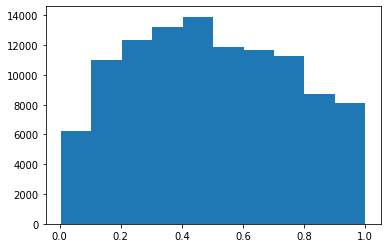

In [20]:
plt.hist(help_df['15'])

In [21]:
#help_df = help_df.sample(frac=.5, random_state=1)

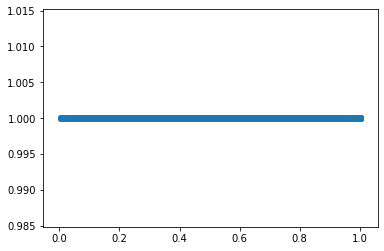

In [22]:
plt.scatter(help_df['15'],help_df['7'])

/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/home/ec2-user/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:898: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

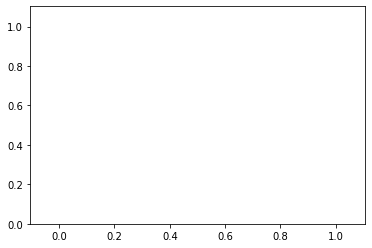

In [23]:
#plt.hist(help_df[help_df['7']==1]['15'],normed=True,alpha=.5,color='red')
#plt.hist(help_df[help_df['7']==2]['15'],normed=True,alpha=.5,color='orange')
#plt.hist(help_df[help_df['7']==3]['15'],normed=True,alpha=.5,color='yellow')
plt.hist(help_df[help_df['7']==4]['15'],normed=True,alpha=.5,color='blue')
plt.hist(help_df[help_df['7']==5]['15'],normed=True,alpha=.5,color='green')

In [24]:
sum(help_df['15']<=.8)

91453

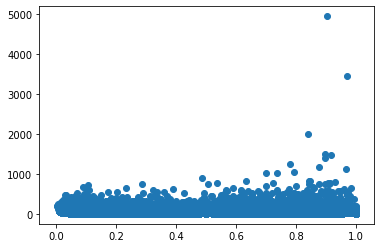

In [25]:
plt.scatter(help_df['15'],help_df['9'])

(0, 200)

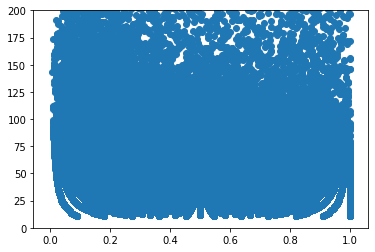

In [26]:
plt.scatter(help_df['15'],help_df['9'])
plt.ylim(0,200)

In [27]:
help_df[help_df['9']>0]['15'].mean()

0.4996124017445298

In [28]:
help_df[help_df['9']>15]['15'].mean()

0.4821437825617578

In [29]:
help_df['9'].median()

27.0

(0, 100)

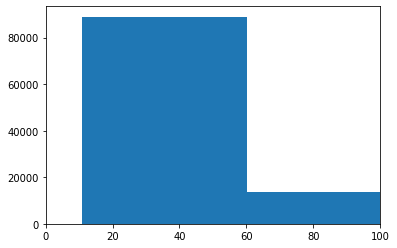

In [30]:
plt.hist(help_df['9'],bins=100)
plt.xlim(0,100)

In [31]:
len(help_df[help_df['9']>3])

108329

In [32]:
sum(help_df['15']>=.66)

33067

In [33]:
sum(help_df['15']<.66)

75262

In [34]:
good_df = help_df[help_df['15']>=.66]
bad_df = help_df[help_df['15']<.66]